In [1]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

#### Helper Plot Functions

In [2]:
def datetime_plot(plot_items, figsize=(15, 5)):
    ''''Plots multiple datetime data given a timeseries range and values to plot.'''
    
    year_locator = mdates.YearLocator()
    month_locator = mdates.MonthLocator(bymonth=range(1,12,3))
    # note: the interval arg rather than bymonth messes up the major and minor fmting
    
    years_fmt = mdates.DateFormatter('%Y %b')
    months_fmt = mdates.DateFormatter('%b')

    fig, ax = plt.subplots(figsize=figsize)
    ax.set(xlabel='Date',
           ylabel='Passengers',
           title='Number of Passengers by Month')
    
    #the actual plotting of items
    for datetimes, values in plot_items:
        ax.plot(datetimes, values)
    
    #autoscales to daterange
    ax.autoscale(axis='x', tight=True)
    
    #set x axis minor tic values and format
    ax.xaxis.set_minor_locator(month_locator)
    ax.xaxis.set_minor_formatter(months_fmt)
    
    #set x axis major tic values and format
    ax.xaxis.set_major_locator(year_locator)
    ax.xaxis.set_major_formatter(years_fmt)
    
    #rotate x axis labels
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
    
    plt.show()

## Load Flight Data

In [3]:
'''Raw Data Load'''
flight_data = sns.load_dataset("flights")
flight_data['datetime'] = pd.to_datetime(flight_data.year.astype(str) + flight_data.month.astype(str), format='%Y%b')
flight_data = flight_data[['passengers', 'datetime']]
flight_data.head()

,passengers,datetime
0,112,1949-01-01
1,118,1949-02-01
2,132,1949-03-01
3,129,1949-04-01
4,121,1949-05-01


In [4]:
flight_data.count()

passengers    144
datetime      144
dtype: int64

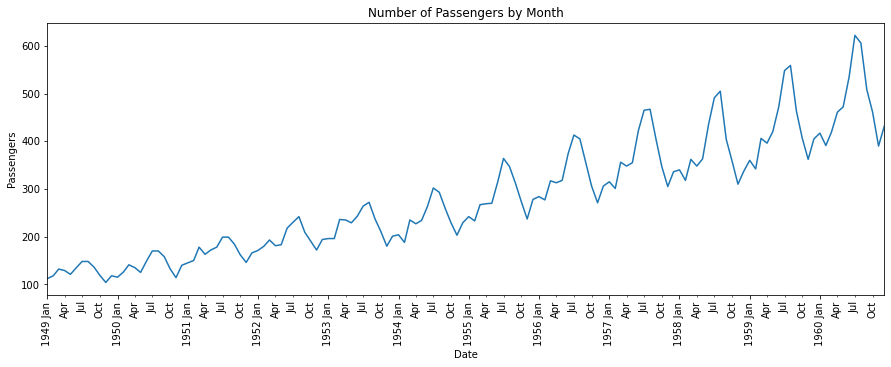

In [5]:
'''Plot Raw Data'''
datetime_plot([[flight_data.datetime, flight_data.passengers]])

## Create Train / Test Data Split

In [6]:
all_data = flight_data['passengers'].values.astype(float)

In [7]:
all_data, len(all_data)

(array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
        118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
        114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
        162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
        209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
        272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
        302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
        315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
        318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
        348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
        362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
        342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
        417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
        432.]),
 144)

In [8]:
window_size = 12

train_data = all_data[:-window_size]
test_data = all_data[-window_size:]

In [9]:
print(len(train_data))
print(len(test_data))

132
12


## Scale Data

In [10]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 1))
train_norm_tensor = torch.FloatTensor(train_data_normalized).view(-1)

In [11]:
'''Take a look at the data we have just transformed'''
print(train_norm_tensor[:13])
print(train_norm_tensor[:12])
print(train_norm_tensor[12])

tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
        -0.8593, -0.9341, -1.0000, -0.9385, -0.9516])
tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
        -0.8593, -0.9341, -1.0000, -0.9385])
tensor(-0.9516)


## Choose window size and create inout sequences
An inout sequence is the data used for the prediction i.e. a window size of data used for a prediction, and the target i.e. the prediction we are making: the number of passengers for a future month.

The ranges of the window and the target are arbitrary. The range of the target come from the question we are attempting to answer with the model. Both ranges will affect the architecture of the model, as well as the model's performance.

In [12]:
def create_inout_sequences(input_tensor, tw):
    '''
        accepts input data, returns a list of tuples
        ([passangers in month 1, ..., passangers in month tw], passangers in month tw + 1)
    '''
    inout_seq = []
    L = len(input_tensor)
    for i in range(L-tw):
        train_seq = input_tensor[i:i+tw]
        train_label = input_tensor[i+tw]
        inout_seq.append((train_seq, train_label))
    return inout_seq


In [13]:
train_inout_seq = create_inout_sequences(train_norm_tensor, window_size)

print(f'Example inout seq:\n\tin:\t{train_inout_seq[0][0]}\n\tout:\t{train_inout_seq[0][0][1]}')

Example inout seq:
	in:	tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
        -0.8593, -0.9341, -1.0000, -0.9385])
	out:	-0.9384615421295166


### Define the model architecture

In [14]:
class LSTM(nn.Module):
    '''Contructor for the LSTM class. Inherits from pytorch nn.
    
        input_size
            is the number of features in the input. (e.g. the one feature: total number of passengers)
        hidden_size
            is the number of features in the hidden state h (the internal state.)
        output_size this is the length of the prediction. (e.g. the number of days we are predicting in the future)
            it is the size of the linear layer.
        
        the linear layer transforms the dimensions of the feature space (i.e. the size of the tensor)
    '''
    def __init__(self, input_size=1, hidden_size=100, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size)

        self.linear = nn.Linear(hidden_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_size),
                            torch.zeros(1,1,self.hidden_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1][0]

MSE is a standard loss function for regression problems.
It encourages small mistakes and penalizes large mistakes.
MSE is defined by:

$$MSE = \sum \hat{P} - Y$$

Where $\hat{P}$ is the predicted value, and $Y$ is the target.

In [58]:
model = LSTM(hidden_size=250)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [59]:
print(model)

LSTM(
  (lstm): LSTM(1, 250)
  (linear): Linear(in_features=250, out_features=1, bias=True)
)


### Training

In [60]:
epochs = 150

for i in range(epochs):
    for in_seq, target in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_size),
                        torch.zeros(1, 1, model.hidden_size))

        pred = model(in_seq)
        loss = loss_function(pred, target)
        
        loss.backward()
        optimizer.step()

    if i%25 == 0:
        print(f'epoch: {i:3} loss: {loss.item():10.8f}')

print(f'epoch: {i:3} loss: {loss.item():10.10f}')

epoch:   0 loss: 0.03508664
epoch:  25 loss: 0.00091767
epoch:  50 loss: 0.00165242
epoch:  75 loss: 0.01234953
epoch: 100 loss: 0.00149220
epoch: 125 loss: 0.00009721
epoch: 149 loss: 0.0074790260


## Using the model to make predictions


We now take the last 12 months of data, the testing data, separated out from the training data at the begining of the notebook, and use the trained model to make predictions.

The process to do this is, using the last 12 months of training data, we predict the 13 month of data. Now, using the last 11 months of data and the newly predicted 13th month of data, we predict the 14th month. This process repeats until we have 12 months of entirely predicted data.

We will then compare these 12 predicted months with the actual 12 months of data that was set aside.

In [61]:
#get the last 12 months from the training data
test_inputs = train_norm_tensor[-window_size:].tolist()
# print(test_inputs)

[0.12527473270893097, 0.04615384712815285, 0.3274725377559662, 0.2835164964199066, 0.3890109956264496, 0.6175824403762817, 0.9516483545303345, 1.0, 0.5780220031738281, 0.33186814188957214, 0.13406594097614288, 0.32307693362236023]


In [62]:
model.eval()
for i in range(window_size):
    seq = torch.FloatTensor(test_inputs)
    #using no grad bc we dont need to compute the gradient for using the model.
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_size),
                        torch.zeros(1, 1, model.hidden_size))
        test_inputs.append(model(seq).item())

In [63]:
#get the 12 months of data that was just predicted (these values are in the range (0, 1))
predictions = np.array(test_inputs[window_size:])

#transform the predicted values to their actual values
actual_predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
# print(actual_predictions)

[[394.82661733]
 [378.38033987]
 [416.61841491]
 [417.57907712]
 [454.85824937]
 [589.34214556]
 [670.00593269]
 [595.83616519]
 [456.24374816]
 [365.72073875]
 [393.22871381]
 [442.89655724]]


In [64]:
'''Artificially create the daterange for the months that we just predicted'''
predictions_daterange = flight_data.datetime[-window_size:]
# print(predictions_daterange)

132   1960-01-01
133   1960-02-01
134   1960-03-01
135   1960-04-01
136   1960-05-01
137   1960-06-01
138   1960-07-01
139   1960-08-01
140   1960-09-01
141   1960-10-01
142   1960-11-01
143   1960-12-01
Name: datetime, dtype: datetime64[ns]


### Ploting Data and Predictions
#### Plotting the origional dataset in blue, and the predicted values for the last 12 months in orange.

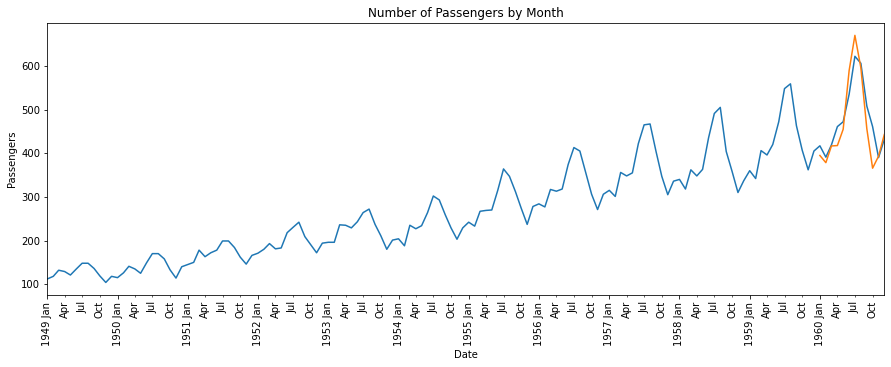

In [65]:
datetime_plot([
    (flight_data.datetime, flight_data.passengers),
    (predictions_daterange, actual_predictions)
    ])

## Observations:
### We see the model vaugley captures the trend in seasonality. Observing the raw data, we see that the total number of passengers has an upwards climb peaking in July, and then the number of passengers decreases hitting its annual low point around October / November. Year by year, the total number of passengers increases following this seasonal trend.

## Conclusions:

### This project is a small introduction to building LSTM models in PyTorch. I learned how to define an LSTM network and use it to make predictions on time series data.

### I observed adding more hidden states and hyperparamater tuning including training for a more epochs will improve the models accuracy.

### While the predicted values did not perfectly allign with the actual values, it should be noted that more data, a longer training window, and more features about the flights or related airline info may give the model more information upon which to train and make predictions.

## Farewell
### I hope this provided you with some basic insights in LSTM architecture and things to consider while working with time series data.